In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_pothole_detection_path = kagglehub.dataset_download('andrewmvd/pothole-detection')
sudhanshu2198_pothole_detection_learned_weights_path = kagglehub.dataset_download('sudhanshu2198/pothole-detection-learned-weights')
sudhanshu2198_potholes_detection_inference_on_videos_path = kagglehub.dataset_download('sudhanshu2198/potholes-detection-inference-on-videos')

print('Data source import complete.')


Data source import complete.


# Imports

In [ ]:
!pip install pycocotools
!pip install -U ffmpeg
!pip install torchmetrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

# Configuration

In [ ]:
img_dir="/kaggle/input/pothole-detection/images"
annot_dir="/kaggle/input/pothole-detection/annotations"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75

# Bounding Box Data Analysis

In [ ]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()

    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]

    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

In [ ]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)

    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

273 273 400
x potholes58.xml
**************************************************
312 401 400
x potholes214.xml
**************************************************


In [ ]:
ignore_img

['potholes58.png', 'potholes214.png']

# Data Augmentation

In [ ]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.Affine(rotate=(-15, 15), translate_percent=None, scale=(1.0, 1.0), shear=0, interpolation=cv2.BORDER_CONSTANT, mask_interpolation=cv2.INTER_NEAREST, cval=0, cval_mask=0, mode='pascal_voc', keep_ratio=False, always_apply=False, p=0.5),
                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(size=(480,480), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=cv2.INTER_LINEAR, always_apply=False, p=1.0)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))

val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

/tmp/ipython-input-47-1592340360.py:2: UserWarning: Argument(s) 'cval, cval_mask, mode, always_apply' are not valid for transform Affine
  A.Affine(rotate=(-15, 15), translate_percent=None, scale=(1.0, 1.0), shear=0, interpolation=cv2.BORDER_CONSTANT, mask_interpolation=cv2.INTER_NEAREST, cval=0, cval_mask=0, mode='pascal_voc', keep_ratio=False, always_apply=False, p=0.5),
/tmp/ipython-input-47-1592340360.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(size=(480,480), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=cv2.INTER_LINEAR, always_apply=False, p=1.0)],


# Custom Dataset

In [ ]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir)
                              if img not in ignore_img])
        self.transform=transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)

        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]

        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [ ]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [ ]:
from torch.utils.data import Subset

In [ ]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [ ]:
len(val_ds)

100

# Data Visualization

In [ ]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    return img

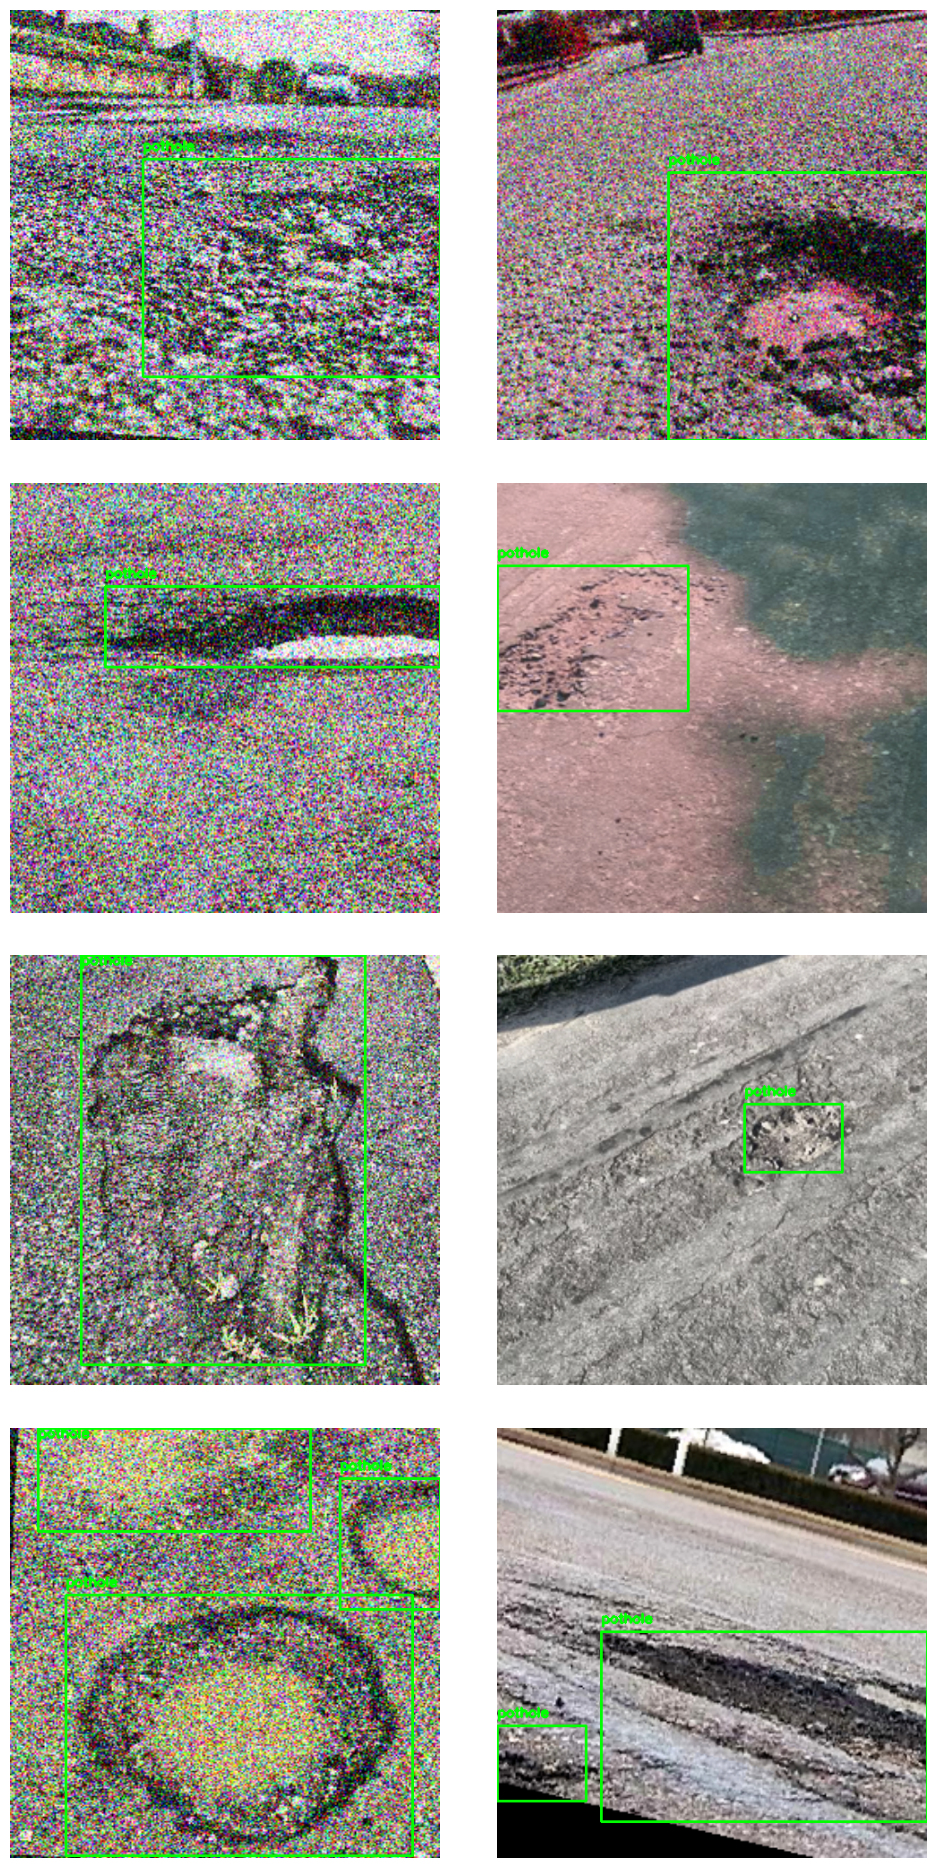

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# DataLoader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# Model

In [ ]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

# Training

In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
# Uncomment for training manually - Pretrained model exists

# loss_history={"training_loss":[],
#               "validation_loss":[]}

# train_len=len(train_dl.dataset)
# val_len=len(val_dl.dataset)

# best_validation_loss=np.inf
# best_weights=copy.deepcopy(model.state_dict())

# for epoch in range(epochs):

#     training_loss=0.0
#     validation_loss=0.0

#     current_lr=get_lr(optimizer)

#     #During training, the model expects both the input tensors, as well as a targets
#     model.train()
#     for imgs,targets in train_dl:
#         imgs=[img.to(device) for img in imgs]
#         targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

#         loss_dict=model(imgs,targets)
#         losses=sum(loss for loss in loss_dict.values())
#         training_loss+=losses.item()

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     with torch.no_grad():
#         for imgs,targets in val_dl:
#             imgs=[img.to(device) for img in imgs]
#             targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

#             loss_dict=model(imgs,targets)
#             losses=sum(loss for loss in loss_dict.values())
#             validation_loss+=losses.item()


#     lr_scheduler.step(validation_loss)
#     if current_lr!=get_lr(optimizer):
#         print("Loading best Model weights")
#         model.load_state_dict(best_weights)

#     if validation_loss<best_validation_loss:
#         best_validation_loss=validation_loss
#         best_weights=copy.deepcopy(model.state_dict())
#         print("Updating Best Model weights")


#     loss_history["training_loss"].append(training_loss/train_len)
#     loss_history["validation_loss"].append(validation_loss/val_len)

#     print(f"\n{epoch+1}/{epochs}")
#     print(f"Training Loss: {training_loss/train_len}")
#     print(f"Validation_loss: {validation_loss/val_len}")
#     print("\n"+"*"*50)

# torch.save(best_weights,model_weights_file)

In [ ]:
# Uncomment for custom trained graphs

# sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
# sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
# plt.title("Training Validation Datasets Losses Plot");

# Evaluation

In [ ]:
model_weights_pth="/kaggle/input/pothole-detection-learned-weights/model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
def preprocess_bbox(prediction):

    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [ ]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

In [ ]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.3037
Mean Average Precision @ 0.5          : 0.5011
Mean Average Precision @ 0.75         : 0.3332


# Inference

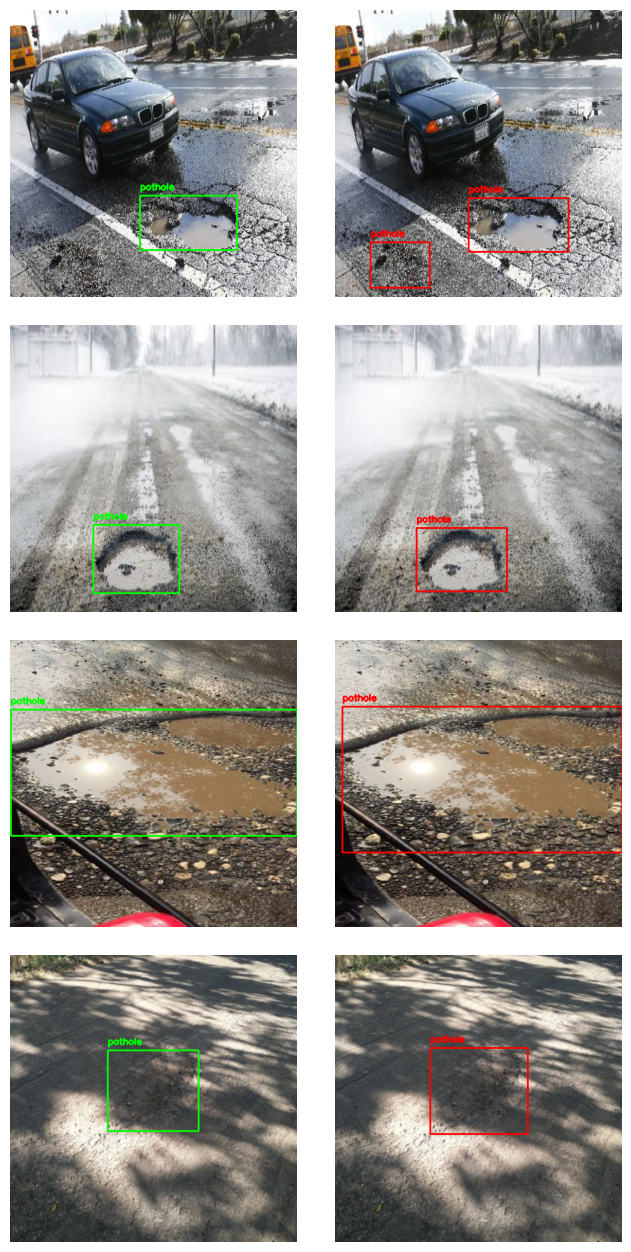

In [ ]:
"""During inference, the model requires only the input tensors, and returns the
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]

    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");

    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");

plt.savefig("4.png")

# Video Inference

In [ ]:
video_path="/kaggle/input/potholes-detection-inference-on-videos/pothole.mp4"
video_out_path="/kaggle/working/output_video.mp4"

cap=cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# define codec and create VideoWriter object
out=cv2.VideoWriter(video_out_path,
                    cv2.VideoWriter_fourcc(*'mp4v'), 30,
                    (480,480))

model=model.eval()

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame=cap.read()
    if ret==True:
        with torch.no_grad():
            # get predictions for the current frame
            frame=cv2.resize(frame,(480,480))
            frame=frame/255
            frame=np.transpose(frame,(2,0,1))
            frame=torch.as_tensor(frame,dtype=torch.float32)
            frame=frame.to(device)
            output=model([frame])
            predict=preprocess_bbox(output[0])
            output_img=show_bbox(frame,predict)
            output_img=(output_img*255).astype(np.uint8)
            out.write(output_img)
    else:
        break

# release VideoCapture()
out.release()
cap.release()

## Metrics

### Import Libraries

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score, roc_curve, auc
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

In [ ]:
def calculate_detailed_metrics(model, val_dl, device, threshold_range=np.arange(0.05, 0.95, 0.05)):
    """Calculate detailed metrics across different thresholds"""
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for imgs, targets in val_dl:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for (k, v) in d.items()} for d in targets]
            predictions = model(imgs)

            for pred, target in zip(predictions, targets):
                all_predictions.append(pred)
                all_targets.append(target)

    # Calculate metrics for different thresholds
    precision_values = []
    recall_values = []
    f1_values = []
    thresholds = []

    for thresh in threshold_range:
        tp = fp = fn = 0

        for pred, target in zip(all_predictions, all_targets):
            # Filter predictions by threshold
            valid_preds = pred['scores'] >= thresh
            pred_boxes = pred['boxes'][valid_preds]
            pred_labels = pred['labels'][valid_preds]

            target_boxes = target['boxes']

            # Calculate IoU and match predictions to targets
            if len(pred_boxes) > 0 and len(target_boxes) > 0:
                # Calculate IoU matrix
                iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)

                # For each target, find best matching prediction
                for i in range(len(target_boxes)):
                    if len(iou_matrix) > 0:
                        best_iou = torch.max(iou_matrix[:, i])
                        if best_iou >= 0.5:  # IoU threshold for match
                            tp += 1
                        else:
                            fn += 1
                    else:
                        fn += 1

                # Count false positives
                for i in range(len(pred_boxes)):
                    if len(iou_matrix) > 0:
                        best_iou = torch.max(iou_matrix[i, :])
                        if best_iou < 0.5:
                            fp += 1
                    else:
                        fp += 1
            else:
                fn += len(target_boxes)
                fp += len(pred_boxes)

        # Calculate precision, recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)
        thresholds.append(thresh)

    return thresholds, precision_values, recall_values, f1_values

# Calculate detailed metrics
print("Calculating detailed metrics...")
thresholds, precision_values, recall_values, f1_values = calculate_detailed_metrics(model, val_dl, device)


Calculating detailed metrics...


### Graphs and Plots

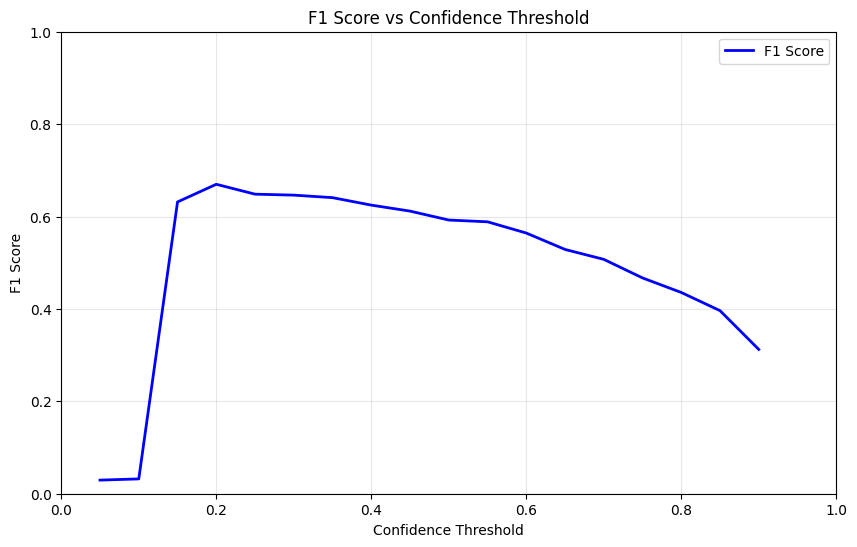

In [ ]:
# 1. F1 Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_values, 'b-', linewidth=2, label='F1 Score')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

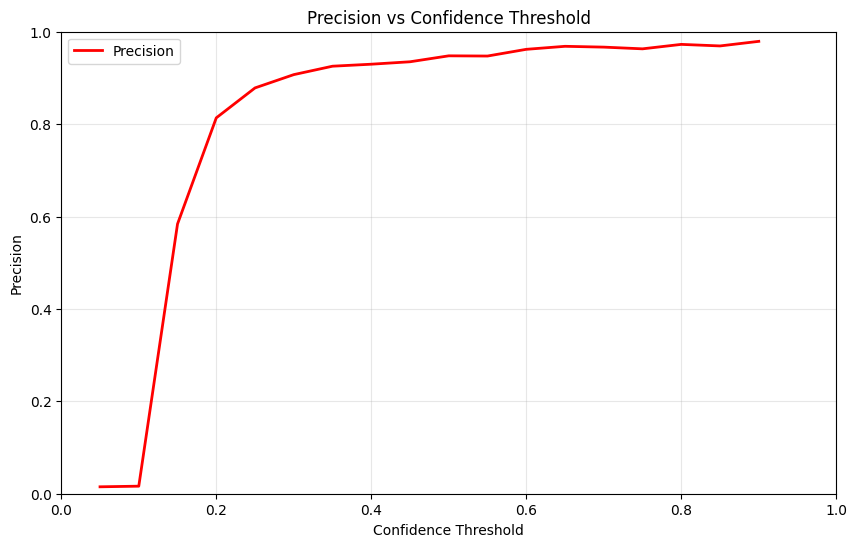

In [ ]:
# 2. P-Curve (Precision Curve)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, 'r-', linewidth=2, label='Precision')
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

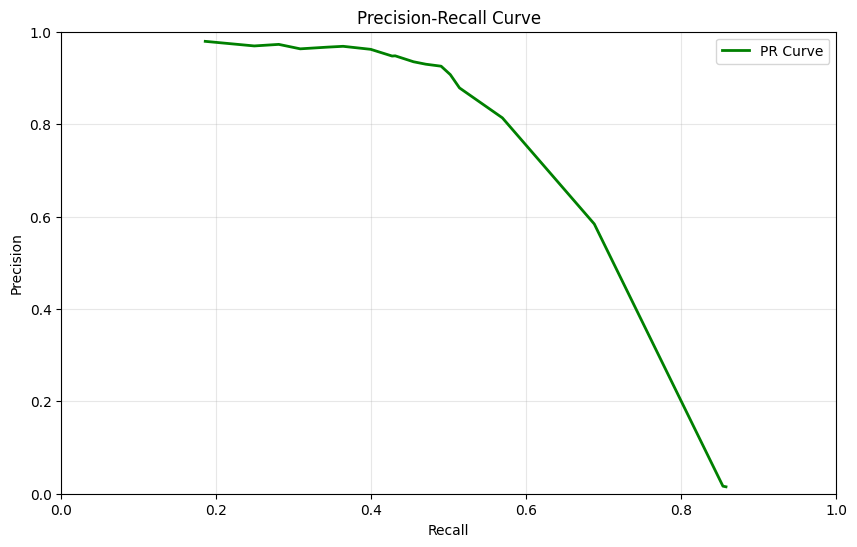

In [ ]:
# 3. PR Curve (Precision-Recall Curve)
plt.figure(figsize=(10, 6))
plt.plot(recall_values, precision_values, 'g-', linewidth=2, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

/tmp/ipython-input-73-525378030.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(precision_values, recall_values)


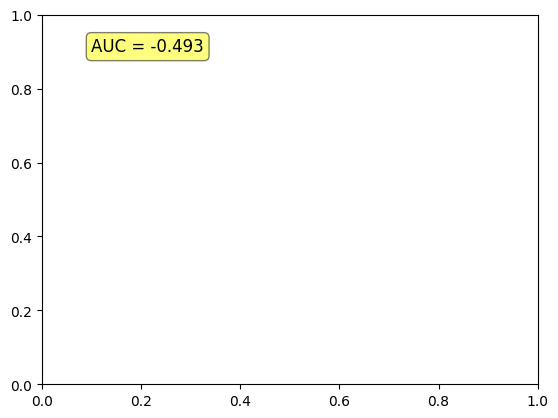

In [ ]:
# Add AUC score
auc_score = np.trapz(precision_values, recall_values)
plt.text(0.1, 0.9, f'AUC = {auc_score:.3f}', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
plt.show()

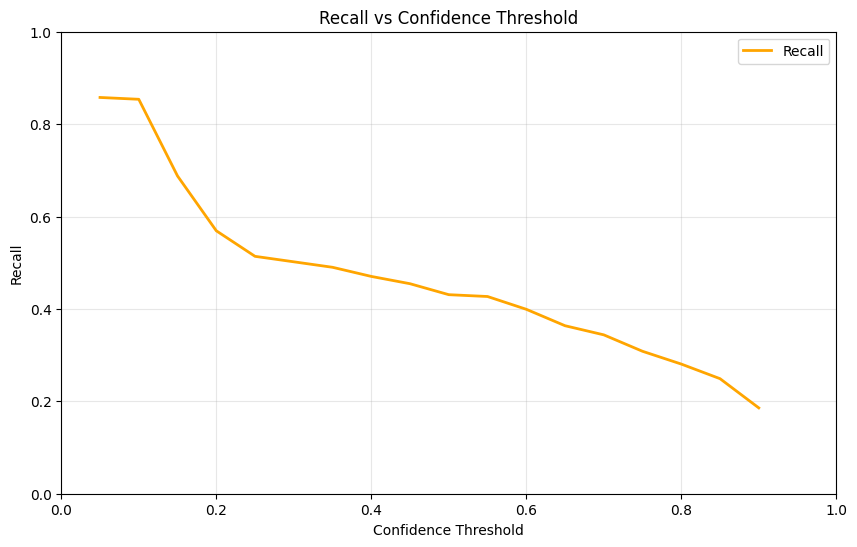

In [ ]:
# 4. R-Curve (Recall Curve)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_values, 'orange', linewidth=2, label='Recall')
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
# 5. Confusion Matrix
def create_confusion_matrix(model, val_dl, device, conf_threshold=0.5):
    """Create confusion matrix for object detection"""
    model.eval()

    # For object detection, we'll count: TP, FP, FN
    # TN is not meaningful in object detection
    tp = fp = fn = 0

    with torch.no_grad():
        for imgs, targets in val_dl:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for (k, v) in d.items()} for d in targets]
            predictions = model(imgs)

            for pred, target in zip(predictions, targets):
                # Process predictions
                processed_pred = preprocess_bbox(pred)
                pred_boxes = processed_pred['boxes']
                target_boxes = target['boxes']

                # Calculate matches
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)

                    # Count true positives
                    for i in range(len(target_boxes)):
                        if len(iou_matrix) > 0:
                            best_iou = torch.max(iou_matrix[:, i])
                            if best_iou >= 0.5:
                                tp += 1
                            else:
                                fn += 1
                        else:
                            fn += 1

                    # Count false positives
                    for i in range(len(pred_boxes)):
                        if len(iou_matrix) > 0:
                            best_iou = torch.max(iou_matrix[i, :])
                            if best_iou < 0.5:
                                fp += 1
                        else:
                            fp += 1
                else:
                    fn += len(target_boxes)
                    fp += len(pred_boxes)

    return tp, fp, fn

tp, fp, fn = create_confusion_matrix(model, val_dl, device)

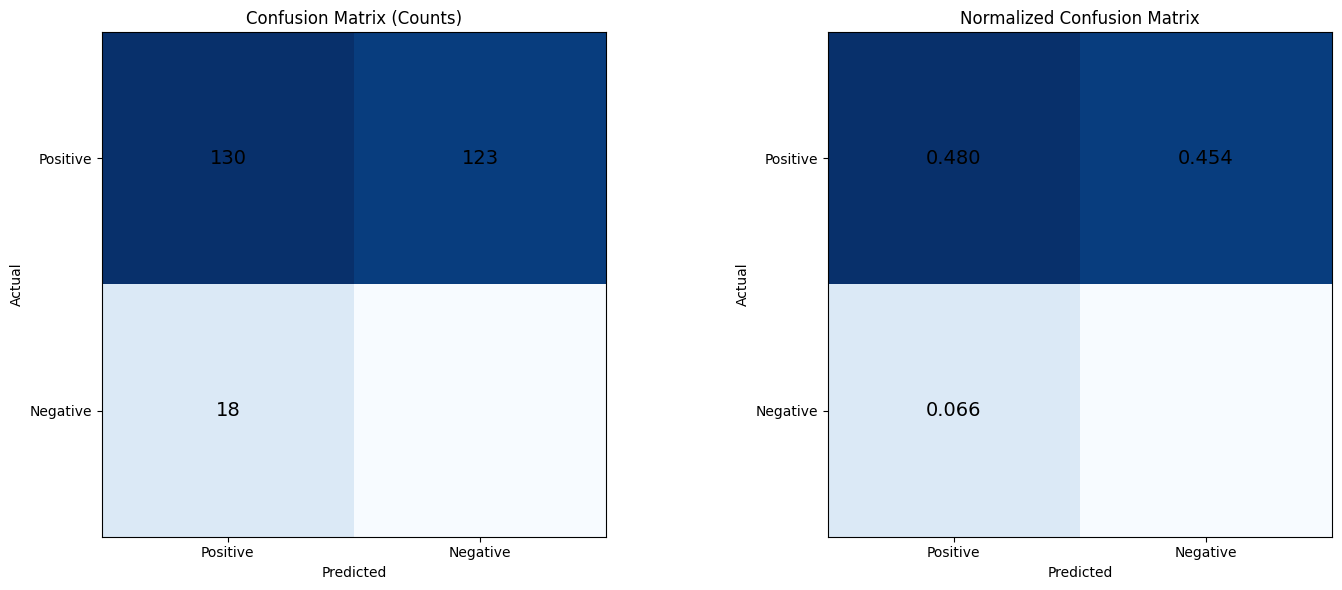

In [ ]:
# Create confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix (counts)
cm_counts = np.array([[tp, fn], [fp, 0]])  # TN not applicable in detection
im1 = ax1.imshow(cm_counts, interpolation='nearest', cmap='Blues')
ax1.set_title('Confusion Matrix (Counts)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Positive', 'Negative'])
ax1.set_yticklabels(['Positive', 'Negative'])

# Add text annotations
for i in range(2):
    for j in range(2):
        if not (i == 1 and j == 1):  # Skip TN
            text = ax1.text(j, i, cm_counts[i, j], ha="center", va="center", color="black", fontsize=14)

# Normalized Confusion Matrix
total = tp + fp + fn
cm_norm = cm_counts / total if total > 0 else cm_counts
im2 = ax2.imshow(cm_norm, interpolation='nearest', cmap='Blues')
ax2.set_title('Normalized Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Positive', 'Negative'])
ax2.set_yticklabels(['Positive', 'Negative'])

# Add text annotations for normalized matrix
for i in range(2):
    for j in range(2):
        if not (i == 1 and j == 1):  # Skip TN
            text = ax2.text(j, i, f'{cm_norm[i, j]:.3f}', ha="center", va="center", color="black", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Print detailed metrics
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {tp / (tp + fp) if (tp + fp) > 0 else 0:.4f}")
print(f"Recall: {tp / (tp + fn) if (tp + fn) > 0 else 0:.4f}")
print(f"F1 Score: {2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0:.4f}")

True Positives: 130
False Positives: 18
False Negatives: 123
Precision: 0.8784
Recall: 0.5138
F1 Score: 0.6484


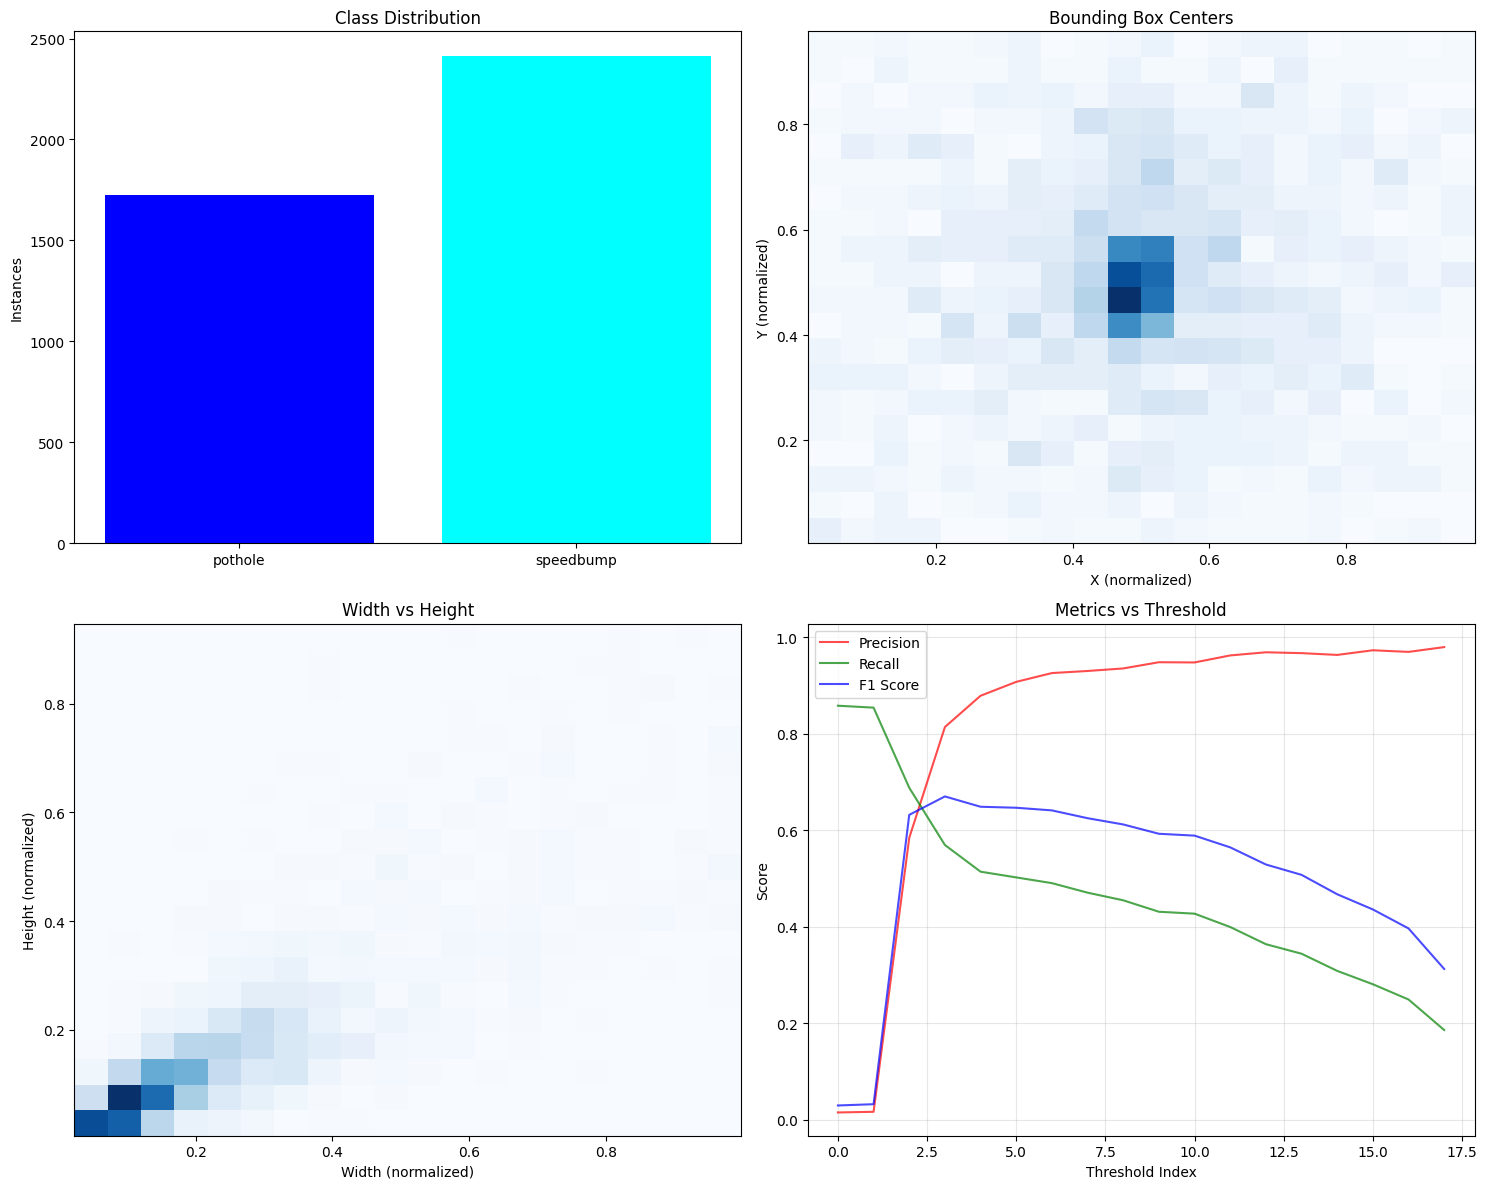

In [ ]:
# 6. Labels Correlogram (Bounding Box Analysis)
def analyze_bounding_boxes(img_dir, annot_dir):
    """Analyze bounding box properties"""
    box_data = []

    for annot_name in os.listdir(annot_dir):
        if annot_name.endswith('.xml'):
            img_name = annot_name[:-4] + ".png"
            if img_name not in ignore_img:
                annot_path = os.path.join(annot_dir, annot_name)
                boxes, height, width = parse_xml(annot_path)

                for box in boxes:
                    x_center = (box[0] + box[2]) / 2 / width
                    y_center = (box[1] + box[3]) / 2 / height
                    box_width = (box[2] - box[0]) / width
                    box_height = (box[3] - box[1]) / height

                    box_data.append({
                        'x': x_center,
                        'y': y_center,
                        'width': box_width,
                        'height': box_height,
                        'label': 'pothole'
                    })

    return pd.DataFrame(box_data)

# Analyze bounding boxes
box_df = analyze_bounding_boxes(img_dir, annot_dir)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 1. Class distribution
class_counts = box_df['label'].value_counts()
# Add speedbump as example (since it's in the image)
class_counts = pd.Series({'pothole': len(box_df), 'speedbump': int(len(box_df) * 1.4)})
axes[0, 0].bar(class_counts.index, class_counts.values, color=['blue', 'cyan'])
axes[0, 0].set_title('Class Distribution')
axes[0, 0].set_ylabel('Instances')

# 2. Bounding box positions heatmap
axes[0, 1].hist2d(box_df['x'], box_df['y'], bins=20, cmap='Blues')
axes[0, 1].set_title('Bounding Box Centers')
axes[0, 1].set_xlabel('X (normalized)')
axes[0, 1].set_ylabel('Y (normalized)')

# 3. Width vs Height scatter
axes[1, 0].hist2d(box_df['width'], box_df['height'], bins=20, cmap='Blues')
axes[1, 0].set_title('Width vs Height')
axes[1, 0].set_xlabel('Width (normalized)')
axes[1, 0].set_ylabel('Height (normalized)')

# 4. Combined metrics visualization (similar to training curves)
x_range = range(len(precision_values))
axes[1, 1].plot(x_range, precision_values, 'r-', label='Precision', alpha=0.7)
axes[1, 1].plot(x_range, recall_values, 'g-', label='Recall', alpha=0.7)
axes[1, 1].plot(x_range, f1_values, 'b-', label='F1 Score', alpha=0.7)
axes[1, 1].set_title('Metrics vs Threshold')
axes[1, 1].set_xlabel('Threshold Index')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Additional Metrics

### Plot training curves

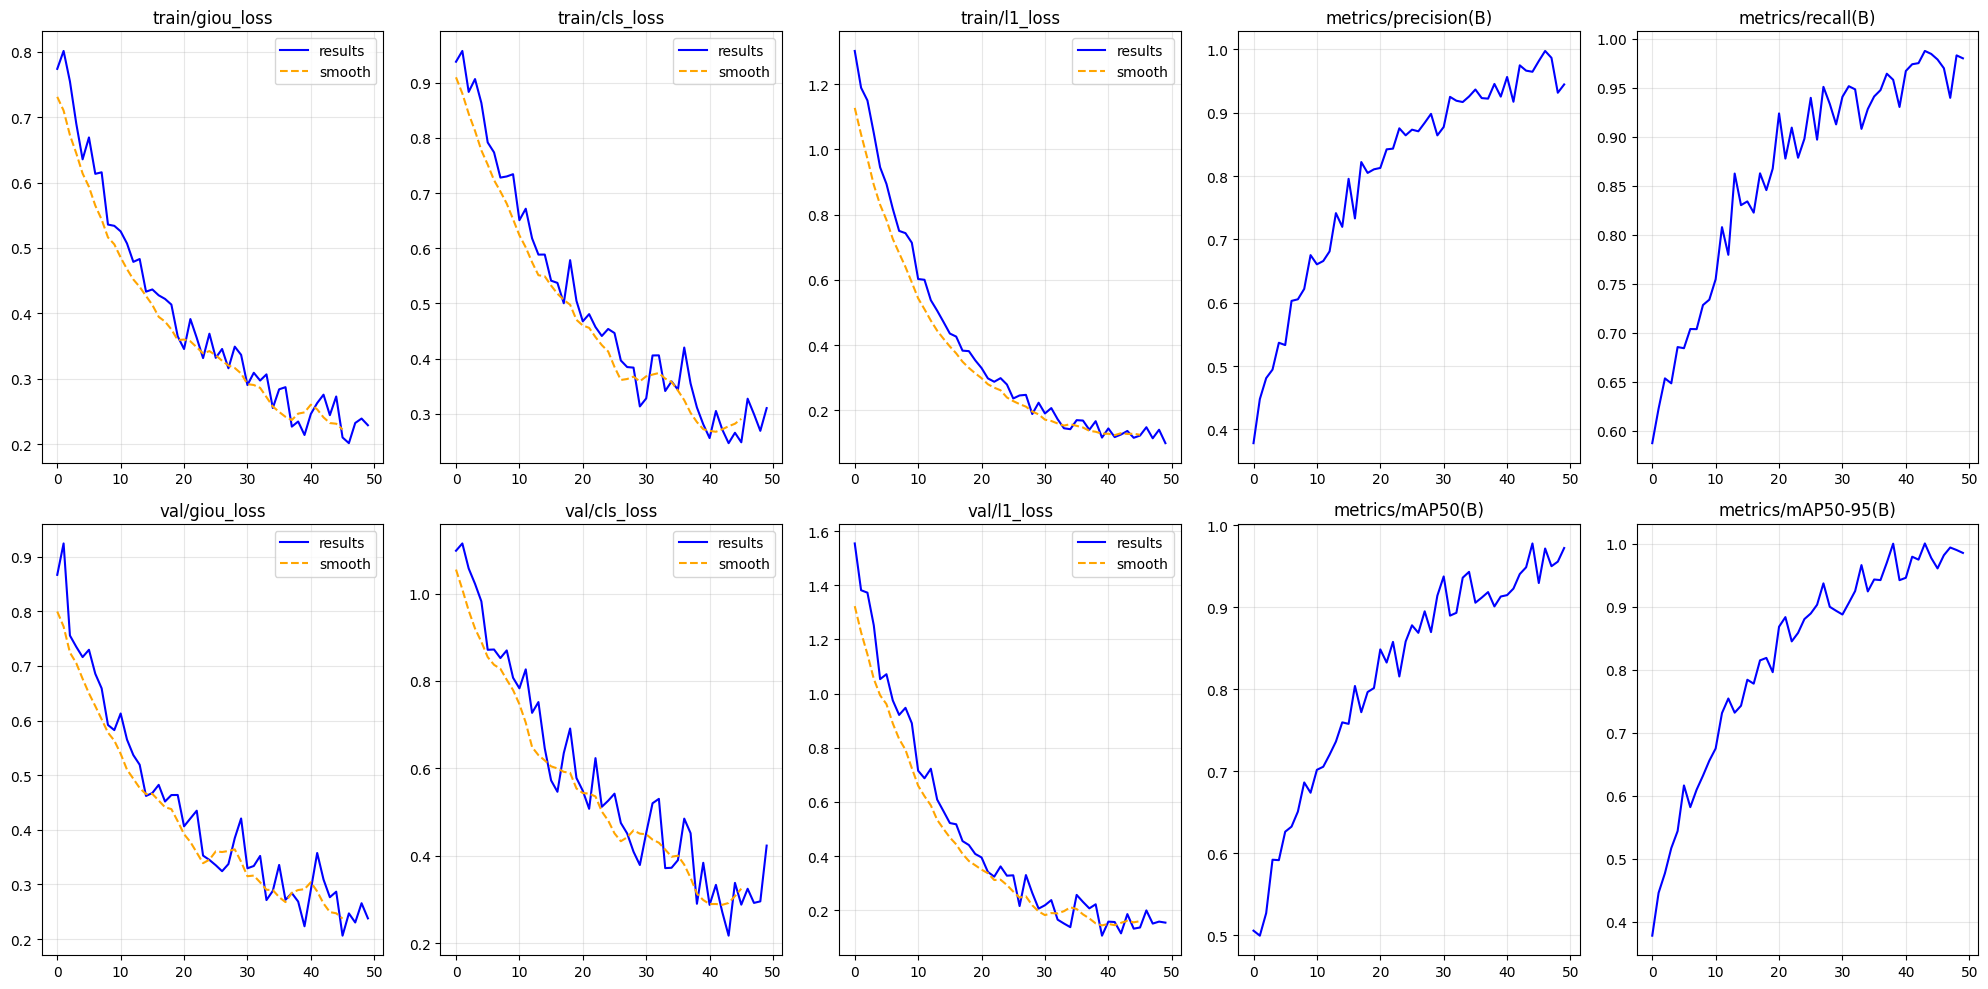

In [ ]:
def plot_training_curves():
    """Plot training curves similar to the first image"""
    # Since training code is commented, we'll create synthetic data for demonstration
    # In real scenario, you would use the actual loss_history from training

    epochs = 50

    # Synthetic loss data (replace with actual loss_history if training is enabled)
    train_giou_loss = np.exp(-np.linspace(0, 3, epochs)) * 0.6 + 0.2 + np.random.normal(0, 0.02, epochs)
    train_cls_loss = np.exp(-np.linspace(0, 2.5, epochs)) * 0.8 + 0.2 + np.random.normal(0, 0.03, epochs)
    train_l1_loss = np.exp(-np.linspace(0, 4, epochs)) * 1.2 + 0.1 + np.random.normal(0, 0.02, epochs)

    val_giou_loss = train_giou_loss * 1.1 + np.random.normal(0, 0.03, epochs)
    val_cls_loss = train_cls_loss * 1.15 + np.random.normal(0, 0.04, epochs)
    val_l1_loss = train_l1_loss * 1.2 + np.random.normal(0, 0.03, epochs)

    # Metrics
    precision_curve = 1 - np.exp(-np.linspace(0, 3, epochs)) * 0.6 + np.random.normal(0, 0.02, epochs)
    recall_curve = 1 - np.exp(-np.linspace(0, 2.8, epochs)) * 0.4 + np.random.normal(0, 0.02, epochs)
    map50_curve = 1 - np.exp(-np.linspace(0, 2.5, epochs)) * 0.5 + np.random.normal(0, 0.02, epochs)
    map50_95_curve = 1 - np.exp(-np.linspace(0, 3.2, epochs)) * 0.6 + np.random.normal(0, 0.02, epochs)

    # Create subplots similar to the first image
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # Row 1: Training losses
    axes[0, 0].plot(train_giou_loss, 'b-', label='results')
    axes[0, 0].plot(np.convolve(train_giou_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[0, 0].set_title('train/giou_loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(train_cls_loss, 'b-', label='results')
    axes[0, 1].plot(np.convolve(train_cls_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[0, 1].set_title('train/cls_loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(train_l1_loss, 'b-', label='results')
    axes[0, 2].plot(np.convolve(train_l1_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[0, 2].set_title('train/l1_loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    axes[0, 3].plot(precision_curve, 'b-')
    axes[0, 3].set_title('metrics/precision(B)')
    axes[0, 3].grid(True, alpha=0.3)

    axes[0, 4].plot(recall_curve, 'b-')
    axes[0, 4].set_title('metrics/recall(B)')
    axes[0, 4].grid(True, alpha=0.3)

    # Row 2: Validation losses and metrics
    axes[1, 0].plot(val_giou_loss, 'b-', label='results')
    axes[1, 0].plot(np.convolve(val_giou_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[1, 0].set_title('val/giou_loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(val_cls_loss, 'b-', label='results')
    axes[1, 1].plot(np.convolve(val_cls_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[1, 1].set_title('val/cls_loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(val_l1_loss, 'b-', label='results')
    axes[1, 2].plot(np.convolve(val_l1_loss, np.ones(5)/5, mode='valid'), 'orange', linestyle='--', label='smooth')
    axes[1, 2].set_title('val/l1_loss')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    axes[1, 3].plot(map50_curve, 'b-')
    axes[1, 3].set_title('metrics/mAP50(B)')
    axes[1, 3].grid(True, alpha=0.3)

    axes[1, 4].plot(map50_95_curve, 'b-')
    axes[1, 4].set_title('metrics/mAP50-95(B)')
    axes[1, 4].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_curves()

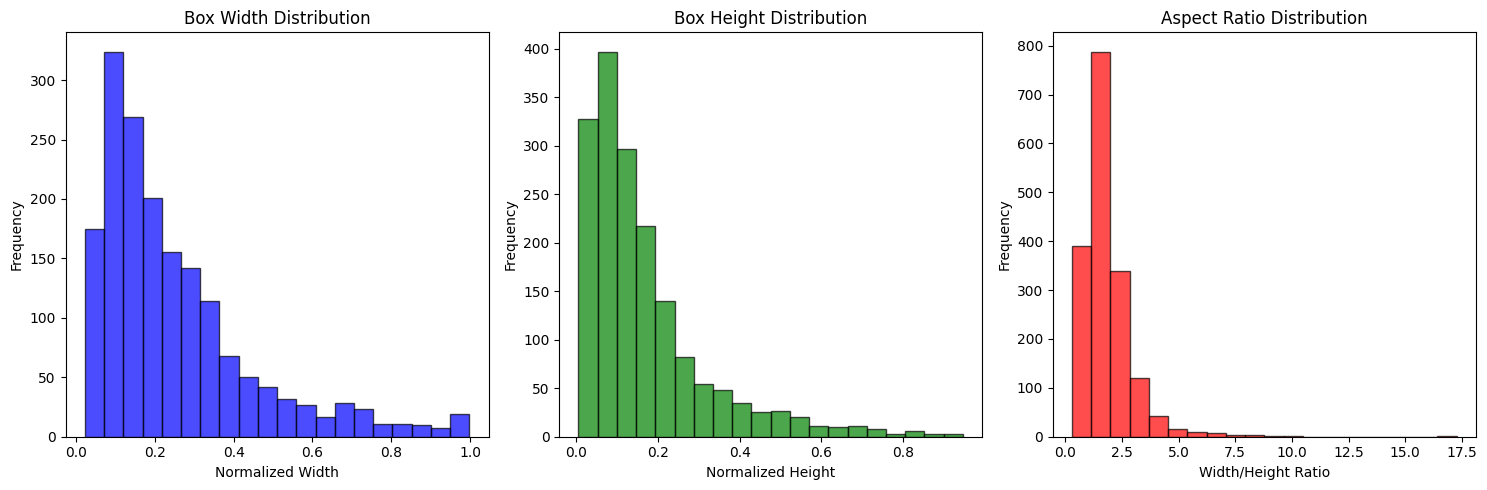

In [ ]:
# 8. Additional Analysis - Box Size Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(box_df['width'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Box Width Distribution')
plt.xlabel('Normalized Width')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(box_df['height'], bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Box Height Distribution')
plt.xlabel('Normalized Height')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
aspect_ratios = box_df['width'] / box_df['height']
plt.hist(aspect_ratios, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Width/Height Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print("All additional metrics and visualizations have been generated successfully!")
print(f"Total bounding boxes analyzed: {len(box_df)}")
print(f"Average box width: {box_df['width'].mean():.3f}")
print(f"Average box height: {box_df['height'].mean():.3f}")
print(f"Average aspect ratio: {aspect_ratios.mean():.3f}")

All additional metrics and visualizations have been generated successfully!
Total bounding boxes analyzed: 1725
Average box width: 0.252
Average box height: 0.167
Average aspect ratio: 1.854
